<a href="https://colab.research.google.com/github/georgehughes1998/Mandelbrot/blob/master/mandelbrot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt

import time, sys, itertools

from google.colab import files#, drive
# drive.mount('/content/gdrive')

In [ ]:
# Mandelbrot Constants
PRECISION = 0.0005#0.00001
PRECISION_ROUND = min([(n if round(PRECISION, n) == PRECISION else 10) for n in range(8)])

XOFFSET = 0
YOFFSET = 0
SCALE = 1

DEPTH = 1000

MINX, MAXX = -2, 1
MINY, MAXY = -1, 1

USETYPE = 1
DATATYPE = ['complex128', 'complex64'][USETYPE]
CDATATYPE = ['complex<double>', 'complex<float>'][USETYPE]

XRANGE = np.arange(MINX, MAXX, PRECISION)
YRANGE = np.arange(MINY, MAXY, PRECISION)
XRANGE_INDEX = range(len(XRANGE))
YRANGE_INDEX = range(len(YRANGE))

SHAPE = len(YRANGE), len(XRANGE)

X_SPLIT = 4
Y_SPLIT = 4

USE_COLOUR = True
if USE_COLOUR:
  SHAPE = SHAPE + (3,)

SAVE_FILE = "mandelbrot.png"
MEMMAP_FILE = "mandelbrot_arr.dat"

In [ ]:
kernel_name = 'mandelbrot'
inputs=f'{DATATYPE} c, {DATATYPE} z, int16 depth'
outputs=f'{DATATYPE} res'
kernel = '''
  res=znplus1(c, z, depth)
'''
CAST = f'({CDATATYPE})'
# znplus1_func = f'''
#   __device__ complex<float> znplus1(complex<float> c, complex<float> z, int depth){{
#     if (depth == 0 || z > {CAST}2) {{return z;}}
#     else {{return znplus1(c, (z*z) + (c/({CAST}{SCALE})) + ({CAST}{XOFFSET}), depth-1);}}
#   }}
# '''
znplus1_func = f'''
  __device__ {CDATATYPE} znplus1({CDATATYPE} c, {CDATATYPE} z, int depth){{
    {CDATATYPE} res = z;
    int count;
    for (count = depth; count > 0; count--)
    {{
        res = (res * res) + (c/({CAST}{SCALE})) + ({CAST}{XOFFSET});
        if (res > {CAST}256) {{return res + {CAST}(depth - count);}}
    }}
    return {CAST}0;
  }}
'''


mandelbrot = cp.ElementwiseKernel(
    inputs,
    outputs,
    kernel,
    kernel_name,
    preamble=znplus1_func)


# Clear mem
grid_gpuxx, grid_gpuyy = None, None
grid_gpu = None
mandelbrot_res = None
mandelbrot_colours = None
mandelbrot_plt = None

mandelbrot_map = np.memmap(MEMMAP_FILE, dtype='uint8', mode='w+', shape=SHAPE)

#-----------------
print("Calculating mandelbrot set...")
start_time = time.time()

XRANGE_GPU = cp.asarray(XRANGE, dtype=DATATYPE) #cp.arange(MINX, MAXX, PRECISION, dtype=DATATYPE)
YRANGE_GPU = cp.asarray(YRANGE, dtype=DATATYPE) #cp.arange(MINY, MAXY, PRECISION, dtype=DATATYPE)

xpos = 0
for chunkx in cp.split(XRANGE_GPU, X_SPLIT):
  # mandelbrot_row = None

  ypos = 0
  for chunky in cp.split(YRANGE_GPU, Y_SPLIT):
    grid_gpuxx, grid_gpuyy = cp.meshgrid(chunkx, chunky)
    grid_gpu = grid_gpuxx + (grid_gpuyy*1j)

    mandelbrot_res = mandelbrot(grid_gpu, 0, DEPTH)

    if USE_COLOUR:
      mandelbrot_colours = cp.dstack((mandelbrot_res.real, mandelbrot_res.imag, cp.zeros(mandelbrot_res.shape)))*255  #mandelbrot_res.real / mandelbrot_res.imag
      mandelbrot_colours = mandelbrot_colours.astype('uint8')
      mandelbrot_colours = cp.clip(mandelbrot_colours, 0, 255)
    else:
      mandelbrot_colours = (mandelbrot_res <= 2).astype('uint8')*255

    mandelbrot_map[ypos:ypos+len(chunky), xpos:xpos+len(chunkx)] = mandelbrot_colours.get()[:]

    ypos += len(chunky)

  ypos = 0
  xpos += len(chunkx)


end_time = time.time()
print(f"Completed in {end_time - start_time}s.")
print()


Calculating mandelbrot set...
Completed in 0.4914259910583496s.



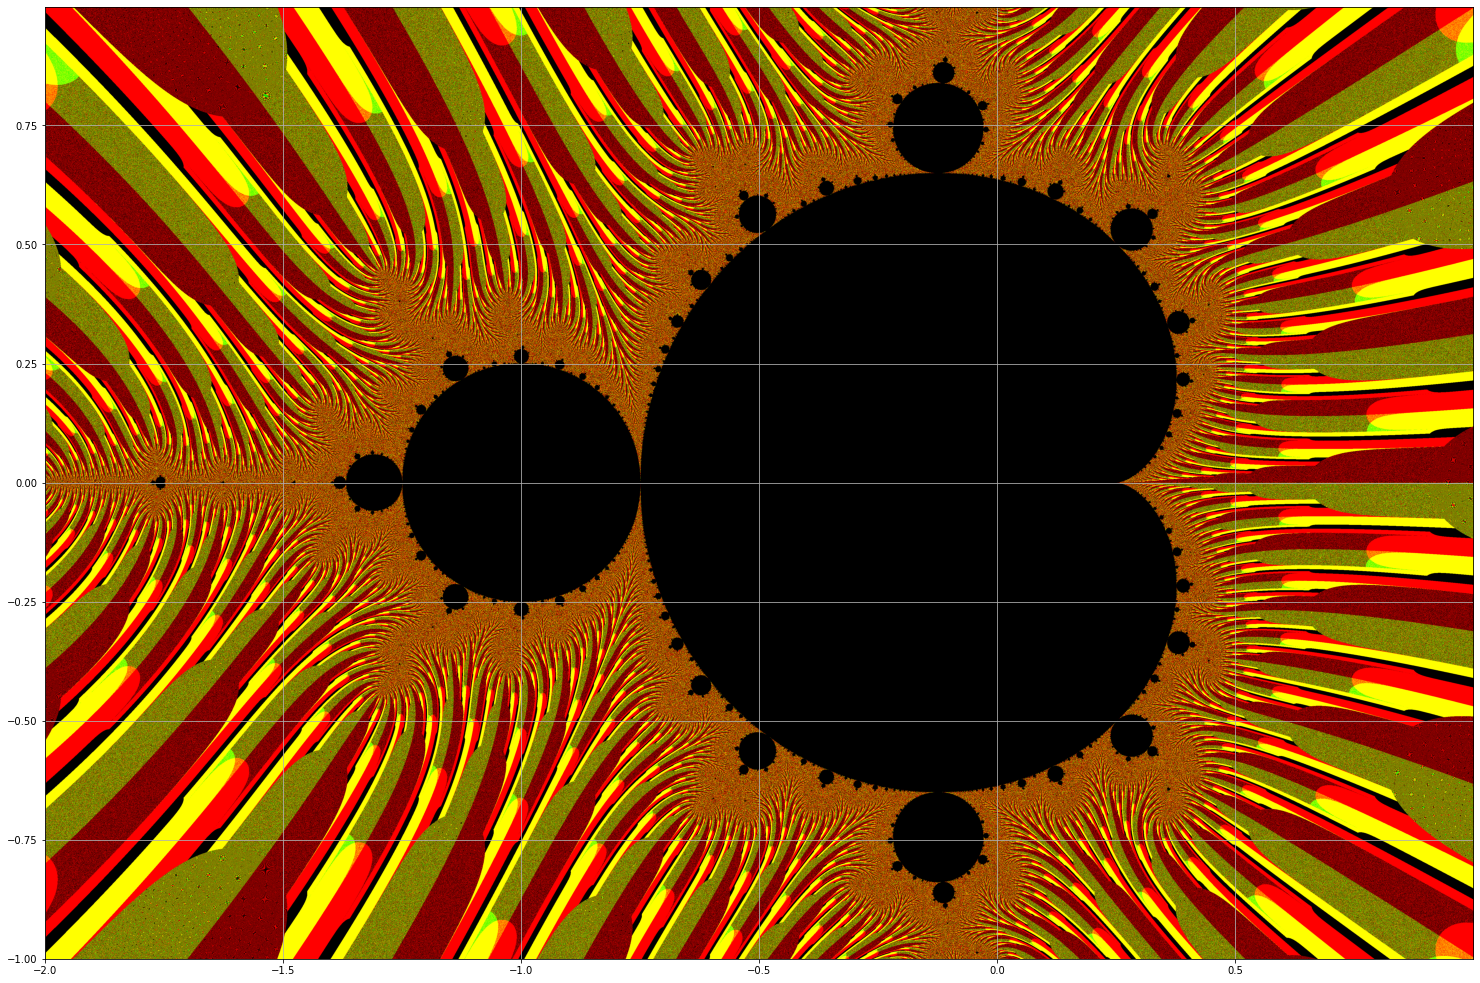

In [ ]:
# Plot image
mandelbrot_map = np.memmap(MEMMAP_FILE, dtype='uint8', mode='r+', shape=SHAPE)

plt.figure(figsize=(25.6, 19.2))
plt.imshow(mandelbrot_map, extent=(XRANGE[0]/SCALE+XOFFSET, XRANGE[-1]/SCALE+XOFFSET, YRANGE[0]/SCALE, YRANGE[-1]/SCALE), cmap='Greys')
plt.grid(True, which='both')
plt.show()

In [ ]:
# Save image to file
from PIL import Image

mandelbrot_map = np.memmap(MEMMAP_FILE, dtype='uint8', mode='r+', shape=SHAPE)

img = Image.fromarray(mandelbrot_map)
img.save(time.asctime() + SAVE_FILE)